In [2]:
import pandas as pd 
import numpy as np 


In [3]:
superstore = pd.read_csv("Superstore.csv",  encoding='ISO-8859-1')

In [4]:
superstore.head() 


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
superstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [6]:
superstore.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [7]:
cols_to_drop = ['Row ID', 'Order ID']
superstore = superstore.drop(columns=cols_to_drop)


In [8]:
superstore['Order Date'] = pd.to_datetime(superstore['Order Date'])
superstore['Ship Date'] = pd.to_datetime(superstore['Ship Date'])


In [9]:
last_date = superstore['Order Date'].max()
cutoff_date = last_date - pd.DateOffset(months=6)

In [10]:
last_order_per_customer = superstore.groupby('Customer ID')['Order Date'].max()
churned_customers = last_order_per_customer[last_order_per_customer < cutoff_date].index


In [11]:
churned_customers

Index(['AA-10315', 'AA-10480', 'AB-10015', 'AC-10420', 'AC-10660', 'AF-10885',
       'AG-10270', 'AG-10525', 'AH-10465', 'AH-10690',
       ...
       'TS-21160', 'TS-21205', 'TS-21340', 'TS-21655', 'TT-21265', 'VD-21670',
       'VG-21805', 'VS-21820', 'VT-21700', 'ZD-21925'],
      dtype='object', name='Customer ID', length=196)

In [12]:
superstore['Churn'] = superstore['Customer ID'].apply(lambda x: 1 if x in churned_customers else 0)


In [13]:
superstore['Churn'].head()

0    1
1    1
2    0
3    0
4    0
Name: Churn, dtype: int64

In [14]:
customer_df = superstore.groupby('Customer ID').agg({
    'Sales': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],
    'Quantity': 'sum',
    'Discount': 'mean',
    'Order Date': ['min', 'max', 'nunique'],
    'Segment': 'first',
    'Region': 'first',
    'Category': lambda x: x.mode()[0],  # most common category
    'Churn': 'first'  # our label
})


In [15]:
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]
customer_df = customer_df.reset_index()


In [16]:
customer_df = customer_df.rename(columns={
    'Sales_sum': 'Total_Sales',
    'Sales_mean': 'Avg_Sales',
    'Profit_sum': 'Total_Profit',
    'Profit_mean': 'Avg_Profit',
    'Order Date_min': 'First_Order_Date',
    'Order Date_max': 'Last_Order_Date',
    'Order Date_nunique': 'Num_Orders'
})
#renamign for clarity

In [17]:
# tenure in days:

customer_df['Tenure'] = (customer_df['Last_Order_Date'] - customer_df['First_Order_Date']).dt.days


In [18]:
customer_df = pd.get_dummies(customer_df, columns=['Segment_first', 'Region_first', 'Category_<lambda>'], drop_first=True)
#converting categorical columns

In [19]:
customer_df = customer_df.drop(columns=['First_Order_Date', 'Last_Order_Date'])


In [20]:
X = customer_df.drop(columns=['Customer ID', 'Churn_first'])
y = customer_df['Churn_first']


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [23]:
X_train.columns = X_train.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)


In [24]:
X.columns = X.columns.str.replace(r"[^A-Za-z0-9_]", "_", regex=True)


In [ ]:
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#fit
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

c:\Users\soumy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

models = {'Logistic Regression': logreg, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       120
           1       0.38      0.21      0.27        39

    accuracy                           0.72       159
   macro avg       0.58      0.55      0.55       159
weighted avg       0.68      0.72      0.69       159

ROC AUC: 0.7884615384615384

Random Forest
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       120
           1       0.45      0.33      0.38        39

    accuracy                           0.74       159
   macro avg       0.62      0.60      0.61       159
weighted avg       0.71      0.74      0.72       159

ROC AUC: 0.7693376068376068

XGBoost
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       120
           1       0.41      0.31      0.35        39

    accuracy                           0.72       159
   macro avg       0.60    

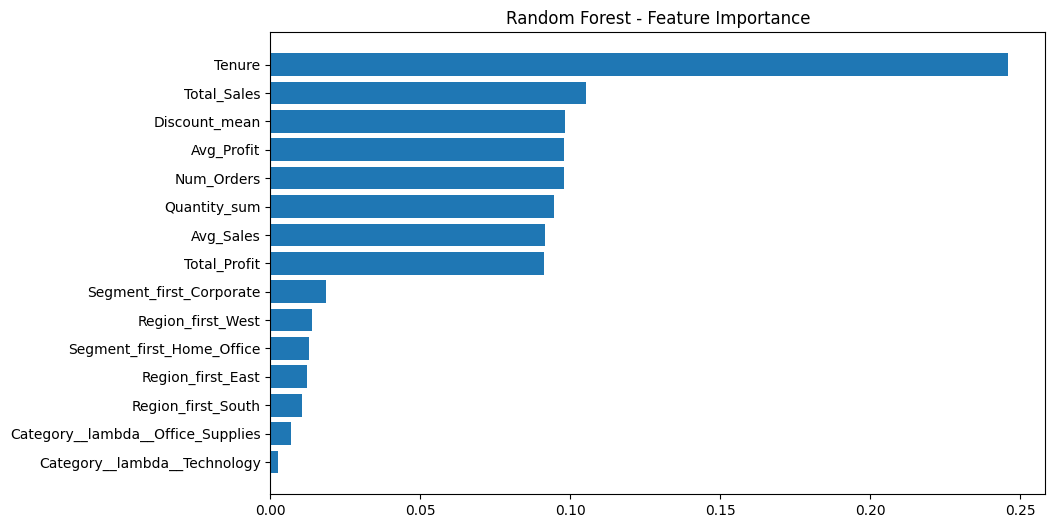

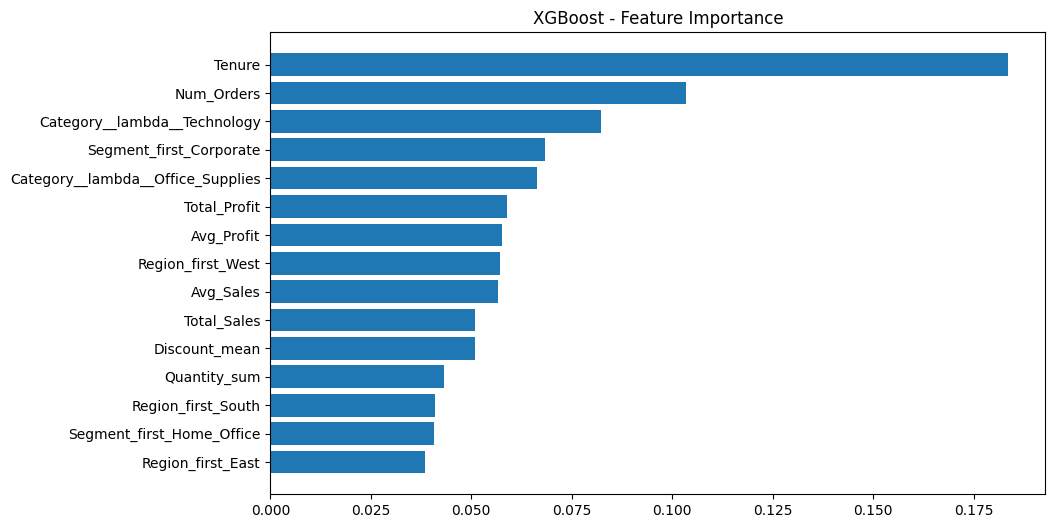

In [ ]:
import matplotlib.pyplot as plt
def plot_feature_importance(model, model_name):
    importance = model.feature_importances_
    features = X.columns
    sorted_idx = importance.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(features[sorted_idx], importance[sorted_idx])
    plt.title(f"{model_name} - Feature Importance")
    plt.show()

plot_feature_importance(rf, "Random Forest")
plot_feature_importance(xgb, "XGBoost")


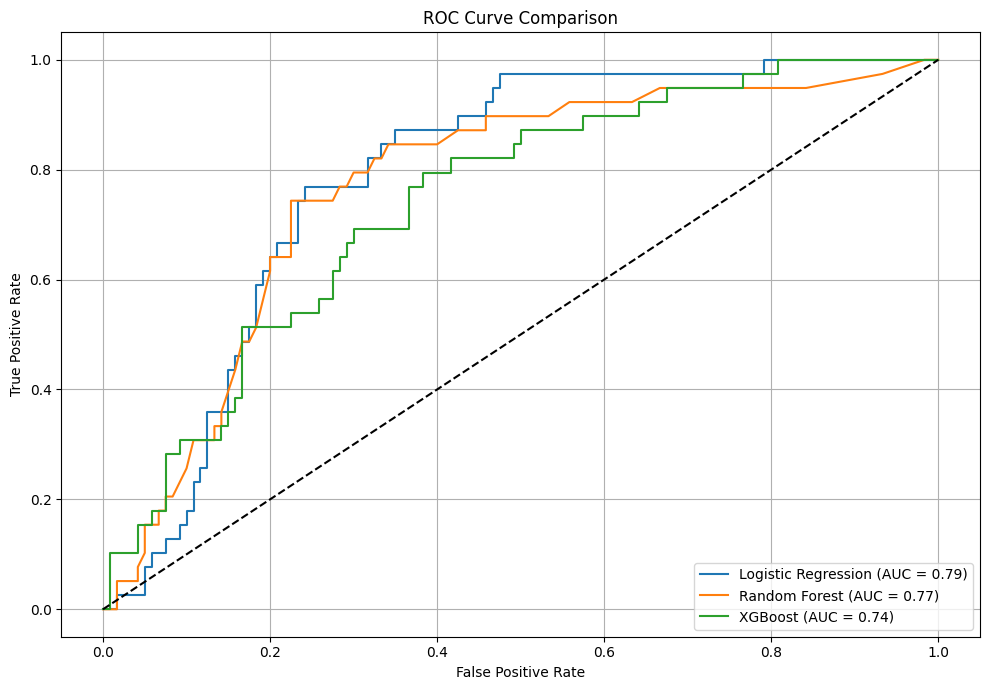

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dictionary of models
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf,
    'XGBoost': xgb
}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--') #making diagonal line jjust to be sure
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


ModuleNotFoundError: No module named 'shap'